In [14]:
from sympy import symbols
from sympy.plotting import plot
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import pandas as pd

from PIL import Image

In [15]:
import os
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import tensorflow_hub as hub

## Importing the dataset

Firstly, the data should be imported into the pandas dataframes for easy manipulation. 

In [16]:
data_dir = "/Users/anna-alexandradanchenko/local/IdentMathFunc/Math-Functions-Identification/data"
img_height = 224
img_width = 224


# Some images are png with transparency. We need to set the white background for them so they won't appear black for the model. 
for subdir, dirs, files in os.walk(data_dir): # Iterate throught all the levels of the directories 
    for file in files:
        if file.endswith('.png'):
            img = Image.open(os.path.join(subdir, file))
            if img.mode == "RGBA":                     # Choose only images with transparency
                white_background_image = Image.new("RGBA", img.size, "WHITE") # Create a white rgba background
                white_background_image.paste(img, (0, 0), img) # Paste original png image on top of the white background
                final_img = white_background_image.convert("RGB")

                final_img.save((os.path.join(subdir, file))) # Save the image with the same filename


# for filename in os.listdir(data_dir):
#     img = Image.open(data_dir + "/" + filename)

In [17]:
# Converts images to floating-point tensors automatically

df_train_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.25,
    subset="training",

    labels='inferred',
    label_mode="categorical",
        
    color_mode='rgb',

    image_size=[img_height, img_width],

    seed = 123,     
    interpolation='bilinear',
    shuffle=True
)

df_valid_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.25,
    subset="validation",
    
    labels='inferred',
    label_mode="categorical",
    
    color_mode='rgb',

    image_size=[img_height, img_width],

    seed = 123,     
    interpolation='bilinear',
    shuffle=False
)


Found 1336 files belonging to 13 classes.
Using 1002 files for training.
Found 1336 files belonging to 13 classes.
Using 334 files for validation.


In [18]:
class_names = df_train_.class_names
print(class_names)

['cubic', 'exponential', 'linear', 'logarithmic', 'negative_cubic', 'negative_exponential', 'negative_linear', 'negative_quadratic', 'negative_square_root', 'not_valid', 'quadratic', 'square_negative_root', 'square_root']


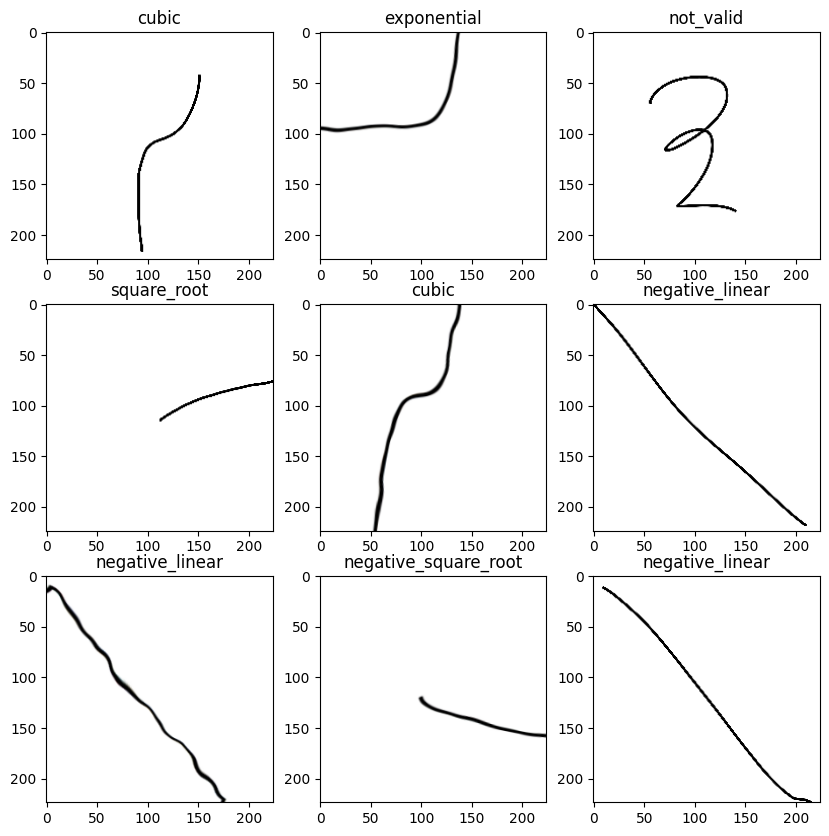

In [19]:
plt.figure(figsize=(10, 10))

for images, labels in df_train_.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_index = np.argmax(labels[i].numpy()) # Returns the indices of the maximum values.
    plt.title(class_names[label_index])



## Dataset Optimization

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

df_train = (
    df_train_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
df_valid = (
    df_valid_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

df_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None))>

In [21]:
for (data, label) in df_train.as_numpy_iterator():
    print(np.max(data))
    print(np.min(data))

255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0
255.0
0.0


## Model Definition

In [73]:
model = Sequential([
    # layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    hub.KerasLayer(
        "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-224-feature-vector/2",
        trainable=False
        ),  
    layers.Flatten(), # Used to transition from convolutional layer to fully connected layer
    layers.Dense(128, activation='relu'),
    layers.Dense(13, activation='softmax')
])

In [74]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [75]:
history = model.fit(
    df_train,
    validation_data=df_valid,
    epochs=8
    )

Epoch 1/8
32/32 [==============================] - 5s 98ms/step - loss: 1.1129 - accuracy: 0.7176 - val_loss: 0.3504 - val_accuracy: 0.9551
Epoch 2/8
32/32 [==============================] - 3s 90ms/step - loss: 0.2069 - accuracy: 0.9721 - val_loss: 0.1566 - val_accuracy: 0.9701
Epoch 3/8
32/32 [==============================] - 3s 104ms/step - loss: 0.1055 - accuracy: 0.9880 - val_loss: 0.0919 - val_accuracy: 0.9850
Epoch 4/8
32/32 [==============================] - 3s 97ms/step - loss: 0.0710 - accuracy: 0.9910 - val_loss: 0.0626 - val_accuracy: 0.9970
Epoch 5/8
32/32 [==============================] - 3s 95ms/step - loss: 0.0494 - accuracy: 0.9970 - val_loss: 0.0443 - val_accuracy: 0.9970
Epoch 6/8
32/32 [==============================] - 3s 94ms/step - loss: 0.0348 - accuracy: 0.9990 - val_loss: 0.0343 - val_accuracy: 0.9970
Epoch 7/8
32/32 [==============================] - 4s 126ms/step - loss: 0.0257 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9970
Epoch 8/8
32/32 [=

<Axes: >

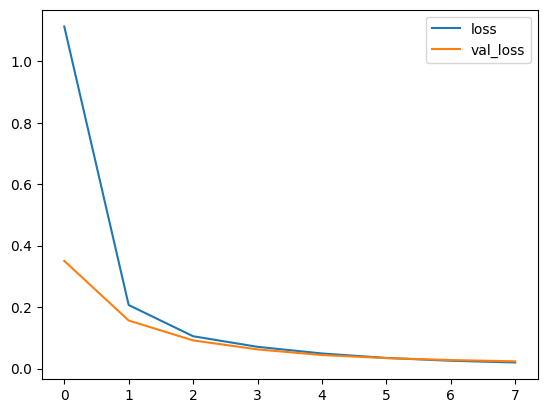

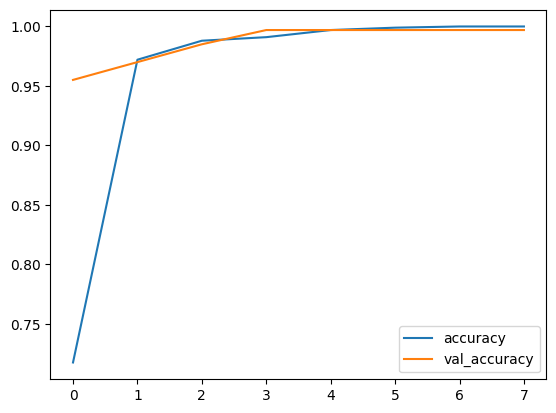

In [76]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

## Save the Model

In [77]:
model.save("model.keras")

In [78]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 1280)              410208    
                                                                 
 flatten_7 (Flatten)         (None, 1280)              0         
                                                                 
 dense_15 (Dense)            (None, 128)               163968    
                                                                 
 dense_16 (Dense)            (None, 13)                1677      
                                                                 
Total params: 575853 (2.20 MB)
Trainable params: 165645 (647.05 KB)
Non-trainable params: 410208 (1.56 MB)
_________________________________________________________________


Test prediction of one image

In [79]:
model_loaded = load_model("model.keras", custom_objects={'KerasLayer':hub.KerasLayer})
img = Image.open("/Users/anna-alexandradanchenko/local/IdentMathFunc/Math-Functions-Identification/data/negative_linear/function_0.9_-1.5_9.0.png").resize((224, 224))
img = np.array(img)
img = np.expand_dims(img, axis=0)
print(img.shape)
prediction = model_loaded.predict(img)
pred_class = np.argmax(prediction)
print(class_names[pred_class])

(1, 224, 224, 3)
1/1 [==============================] - 0s 242ms/step
negative_linear
